In [1]:
!rm -rf AAI.zip AAI
!wget -q "https://www.dropbox.com/s/bnzk44uw48o1clu/AAI.zip"

In [2]:
!unzip -q AAI.zip

In [3]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

print(device)

cuda


In [4]:
!ls AAI/classification

test  train


In [5]:
train_data_dir = 'AAI/classification/train'
test_data_dir = 'AAI/classification/test'




*   Following is a class inherited from the Pytorch Dataset class
*   It includes adding equal number (500) of data in both the target classes
*   get item method returns this index image from the filepath, reads it, crops it to size required by the model, converts it to tensor and permutes it in a way that Pytorch can read it
*   While leveraging pre-trained models, it is mandatory to resize, permute, and then normalize images (as appropriate for that pre- trained model), where the images are first scaled to a value between 0 and 1 across the 3 channels and then normalized to a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225] across the RGB channels.
*   The values used for normalizing are the same mean and standard deviation that was used during the training of the pre-trained model.

In [6]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:,:,::-1] #cv2 imread reads the image as BGR in default, so the code changes it to RGB
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [7]:
data = CatsDogs(train_data_dir)

In [8]:
data.__len__()

1000

tensor([0.], device='cuda:0')
Cat


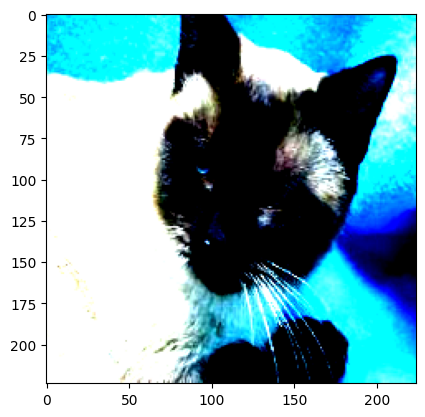

In [9]:
im, label = data[100]
# permute is to just keep it in the matplotlib way to display it
plt.imshow(im.permute(1,2,0).cpu())
print(label)
if label:
    print("Dog")
else:
    print("Cat")

In [10]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) #same as pooling.
    #Stride = (input_size//output_size)  ; Kernel size = input_size - (output_size-1)*stride ; Padding = 0
    #https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [11]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [12]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [13]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [14]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    test = CatsDogs(test_data_dir)
    test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, test_dl

In [15]:
trn_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

In [16]:
train_losses, train_accuracies = [], []
test_accuracies = []

print("All losses and accuracies are for each epoch")
for epoch in range(2):

    train_epoch_losses, train_epoch_accuracies = [], []
    test_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        test_is_correct = accuracy(x, y, model)
        test_epoch_accuracies.extend(test_is_correct)
    test_epoch_accuracy = np.mean(test_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Test Accuracy: {test_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_accuracies.append(test_epoch_accuracy)

All losses and accuracies are for each epoch
 epoch 1/5, Training Loss: 0.29355568607007304, Training Accuracy: 0.9616935483870968, Test Accuracy: 0.9340277777777778
 epoch 2/5, Training Loss: 0.0873309740376088, Training Accuracy: 0.9798387096774194, Test Accuracy: 0.9618055555555556
